In [2]:
import pandas
from cStringIO import StringIO
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sb
import collections
import numpy as np

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
run_prot_df = {}
for id_file in os.listdir("/home/vital/cyano_dataset_20161118/id_filter/"):
    if id_file.endswith(".csv"):
        sample_name = id_file.replace("Fusion_20161115_GM_", "").replace(".csv", "")
        id_file = "/home/vital/cyano_dataset_20161118/id_filter/" + id_file
        prots= StringIO()
        prots_header = []
        with open(id_file) as fh:
            for line in fh:
                if line.startswith("#PROTEIN"):
                    prot_header = line.split("\t")
                elif line.startswith("PROTEIN"):
                    prots.write(line)
        prots.seek(0)
        run_prot_df[sample_name] = pandas.read_csv(prots, sep='\t', header=None, names=prot_header)


In [4]:
#discard contaminants (starting with sp| and decoys):
run_prots = {}
for run, prot_df in run_prot_df.items():
    run_prots[run] = [ac for ac in prot_df.accession if not ac.startswith("sp|") and "rev" not in ac ]
run_prots = collections.OrderedDict(sorted(run_prots.items()))

run_counts = {}
for run, prots in run_prots.items():
    run_counts[run] = len(prots)
run_counts = collections.OrderedDict(sorted(run_counts.items()))

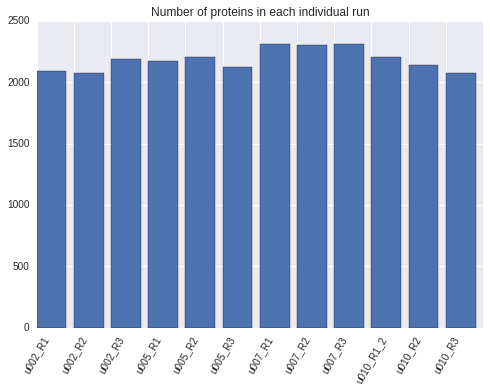

In [5]:
#Plot number of identifications per run
x = range(len(run_counts))
y = run_counts.values()
plt.bar(x, y)
plt.xticks(x, run_counts.keys(), rotation=60)
plt.title("Number of proteins in each individual run")
plt.show()

In [6]:
#get total (across all runs) list of unique proteins. Total number of identified proteins
all_prots = [prot for sublist in run_prots.values() for prot in sublist]
prot_freq = collections.Counter(all_prots)
prot_count = collections.Counter(prot_freq.values())
p = prot_count.values()
prot_ids_in_runs = []
for i in range(len(p)):
    prot_ids_in_runs.append(sum([s for s in p[i:len(p)]]))
percent_prot_ids_in_runs = [i*100/max(prot_ids_in_runs) for i in prot_ids_in_runs]

In [7]:
#Get categories annotations and merge df:
all_prots_categories = pandas.DataFrame()
all_prots_categories["geneID"] = list(set(all_prots))
category_f = "/home/vital/cyano/category.txt"
category_df = pandas.read_csv(category_f, delimiter="\t", header=None)
category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]
cols = ["geneID", "definition", "first_category_name", "second_category_name"]
all_prots_categories_df = pandas.merge(all_prots_categories, category_df[cols], left_on='geneID', right_on='geneID', how='left')

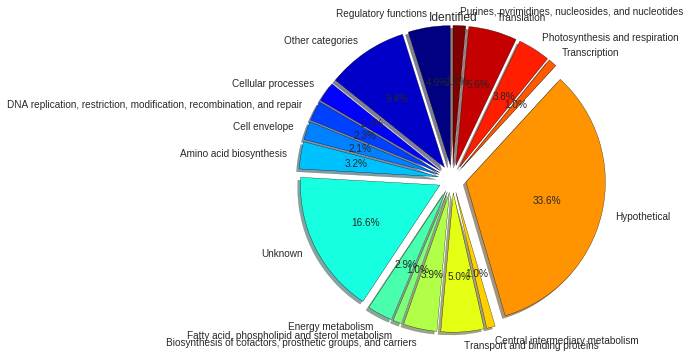

In [8]:
#Pie chart for categories for all identified proteins
category_data = collections.Counter(list(all_prots_categories_df.first_category_name))
category_data_percent = {}
for cat, num in category_data.items():
    category_data_percent[cat] = round(float(num)*100/sum(category_data.values()),2)

# The slices will be ordered and plotted counter-clockwise.
labels = category_data_percent.keys()
sizes = category_data_percent.values()
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(labels)))
explode = [0.1 for i in range(len(labels))]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') # Set aspect ratio to be equal so that pie is drawn as a circle.
plt.title("Identified")
plt.show()

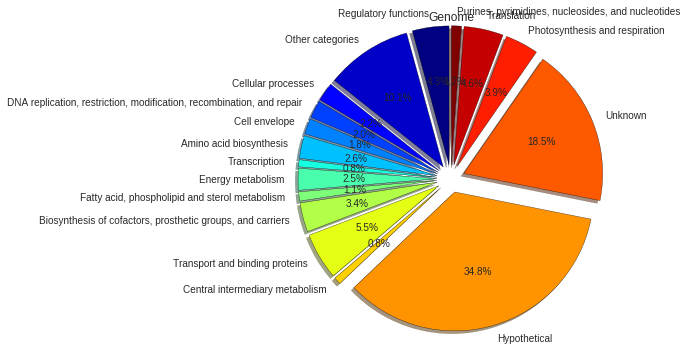

In [9]:
#Compare with Pie chart for categories for all genome:
category_data_genome = collections.Counter(list(category_df.first_category_name))
del category_data_genome['RNA']
category_data_genome_percent = {}
for cat, num in category_data_genome.items():
        category_data_genome_percent[cat] = round(float(num)*100/sum(category_data_genome.values()),2)
labels = category_data_genome_percent.keys()
sizes = category_data_genome_percent.values()
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(labels)))
explode = [0.1 for i in range(len(labels))]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') # Set aspect ratio to be equal so that pie is drawn as a circle.
plt.title("Genome")
plt.show()

In [10]:
#Position frequencies (Chromosome or plasmids)
genes = "/home/vital/cyano_dataset_20161118/genes.txt"
genes_df = pandas.read_csv(genes, delimiter="\t", header=None)
genes_df.columns = ["DataSourceName", "geneID", "Chromosome", "Start", "Stop","Strand", "Description"]
identified = pandas.DataFrame()
identified["geneID"] = list(set(all_prots))
identified_df = pandas.merge(identified, genes_df, left_on='geneID', right_on='geneID', how='left')
location_data = collections.Counter(list(identified_df.Chromosome))
location_data = collections.OrderedDict(sorted(location_data.items()))
location_data_percent = [round(i*100/sum(location_data.values()),2) for i in location_data.values() ]

location_data_reference = collections.Counter(list(genes_df.Chromosome))
location_data_reference = collections.OrderedDict(sorted(location_data_reference.items()))
location_data_reference_percent = [round(i*100/sum(location_data_reference.values()),2) for i in location_data_reference.values() ]


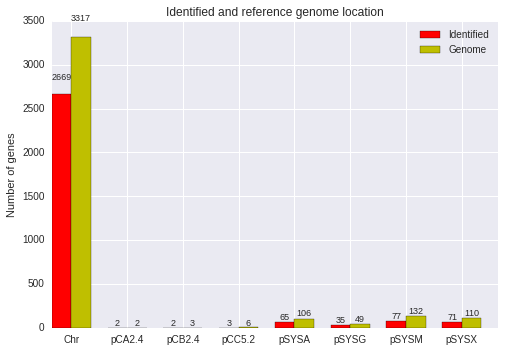

In [11]:
ind = np.arange(len(location_data))  # the x locations for the groups
width = 0.35# the width of the bars

fig, ax = plt.subplots()

location_identified, location_genome = [], []
tick_labels = []
for loc, percent in location_data.items():
    location_identified.append(location_data[loc])
    location_genome.append(location_data_reference[loc])
    tick_labels.append(loc)

rects1 = ax.bar(ind, location_identified, width, color='r')
rects2 = ax.bar(ind + width, location_genome, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel("Number of genes")
ax.set_title('Identified and reference genome location')
ax.set_xticks(ind + width)
ax.set_xticklabels(tick_labels)
ax.legend((rects1[0], rects2[0]), ('Identified', 'Genome'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        #print height
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d'%int(height), ha='center', va='bottom', size=9)

autolabel(rects1)
autolabel(rects2)

plt.show()

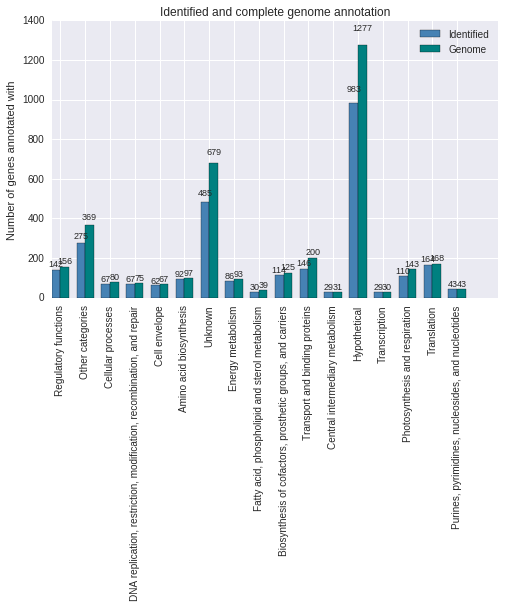

In [12]:
#Categories frequencies for identified set of proteins(genes) and for entire genome
ind = np.arange(len(category_data))  # the x locations for the groups
width = 0.35# the width of the bars

fig, ax = plt.subplots()
categories_identified, categories_genome = [], []
tick_labels = []
for cat, num in category_data.items():
    categories_identified.append(category_data[cat])
    categories_genome.append(category_data_genome[cat])
    tick_labels.append(cat)

rects1 = ax.bar(ind, categories_identified, width, color='steelblue')
rects2 = ax.bar(ind + width, categories_genome, width, color='teal')

# add some text for labels, title and axes ticks
ax.set_ylabel("Number of genes annotated with")
ax.set_title('Identified and complete genome annotation')
ax.set_xticks(ind + width)
ax.set_xticklabels(tick_labels, rotation=90)
ax.legend((rects1[0], rects2[0]), ('Identified', 'Genome'))

autolabel(rects1)
autolabel(rects2)
plt.gcf().subplots_adjust(bottom=0.2)
plt.show()

In [1]:
#One-way ANOVA

from scipy import stats

diffacto_out = "/home/vital/cyano_dataset_20161118/diffacto_out.tsv"
diffacto = pandas.read_csv(diffacto_out, delimiter="\t")
data = pandas.merge(diffacto, genes_df[["geneID","Description"]], left_on="Protein", right_on="geneID", how='left')

#Filter out non - informative proteins S/N greater than -20. See Diffacto manuscript
data = data[data["S/N"] > -20]

samples = [c for c in data.columns if c.startswith("0")]

num_samples = 4
num_replica = 3
for i in numpy.array(samples).reshape(num_samples, num_replica):
    #median = data[i].median(axis=1)
    avg = data[i].mean(axis=1)
    #data[i[0].split("_")[0]+"_median"] = median
    data[i[0].split("_")[0]+"_mean"] = avg

means = ["002_mean", "005_mean", "007_mean", "010_mean"]
data = data[["Protein"]+ samples + means]

for index, row in data.iterrows():
	#Get pandas df for each prot with columns dependent_variable, factor_1 and factor_2:
	prot_df = pandas.DataFrame(columns=["dependent_variable", "group"])
	prot_df.group = [ s.split("_")[0] for s in samples ]
	prot_df.dependent_variable = row[samples].values
	k = len(pandas.unique(prot_df.group))  # number of samples
	N = len(prot_df.values)  # samples times replica
	n = prot_df.groupby('group').size()[0] #num_replica
	DFbetween = k - 1
	DFwithin = N - k
	DFtotal = N - 1
	grand_mean = prot_df.dependent_variable.mean()
	SSbetween = sum( [ n * (prot_df[prot_df.group == g].dependent_variable.mean() - grand_mean)**2 for g in set(list(prot_df.group))] )
	sum_y_squared = sum([value**2 for value in prot_df['dependent_variable'].values])
	SSwithin = sum_y_squared - sum(prot_df.groupby('group').sum()['dependent_variable']**2)/n
	SStotal = sum_y_squared - (prot_df['dependent_variable'].sum()**2)/N
	MSbetween = SSbetween/DFbetween
	MSwithin = SSwithin/DFwithin
	F = MSbetween/MSwithin
	p = stats.f.sf(F, DFbetween, DFwithin)
	data.loc[index, 'p_val'] = p


data.Protein = [p.split(";")[0] for p in data.Protein]
data = data[data["p_val"] < 0.01]
data = pandas.merge(data, category_df[cols], left_on="Protein", right_on="geneID", how='left')

category_data = collections.Counter(list(data.first_category_name))
category_data_percent = {}
for cat, num in category_data.items():
	category_data_percent[cat] = round(float(num)*100/sum(category_data.values()),2)

# The slices will be ordered and plotted counter-clockwise.
labels = category_data_percent.keys()
sizes = category_data_percent.values()
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(labels)))
explode = [0.1 for i in range(len(labels))]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') # Set aspect ratio to be equal so that pie is drawn as a circle.
plt.title("ANOVA p < .01")
plt.show()









translation_set = data[data["first_category_name"] == "Translation"]
photo_set = data[data["first_category_name"] == "Photosynthesis and respiration"]
ribosomal_proteins = data[data.definition.str.contains("ribosomal protein")]
#drop one of the rows so I get 7 to show nicely with legends using cm.rainbow 
#Ideally filter better, or just don't use colors when its a large group
protein_set = ribosomal_proteins.drop(241)
protein_set = photo_set

import matplotlib.patches as mpatches
X = [1,2,3,4]
x_labels = set([c.split("_")[0] for c in samples])
nCols = len(X)

color_patches = []
fig, ax = plt.subplots()
color=iter(plt.cm.rainbow(np.linspace(0,1,len(protein_set))))
for i, row in protein_set.iterrows():
	prot_acc = row.Protein
	prot_descr = row.definition
	Ys = row[samples].values.reshape(4,3).T
	nRows = Ys.shape[0]
	Xs=X*nRows
	c = next(color)
	ax.plot(X, row[means].values, "-", color=c)
	ax.scatter(Xs, Ys.flatten(), color=c)
	patch = mpatches.Patch(color=c, label=prot_acc + " " + prot_descr)
	color_patches.append(patch)
ax.set_ylabel("Abundance")
ax.set_xlabel("Sample")
ax.set_title("Proteins with significant abundance change and \"Photosynthesis and respiration\" as First Category ")
ax.set_xticks(X)
ax.set_xticklabels(sorted(list(x_labels)))
plt.legend(handles=color_patches, loc=0)
plt.show()


NameError: name 'pandas' is not defined